# ÜSKÜDAR ÜNİVERSİTESİ Yapay Sinir Ağları Dersi


In [ ]:
!pip install optuna
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import warnings

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize

warnings.filterwarnings('ignore')

# Tekrarlanabilirlik için
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Kütüphaneler yüklendi ve hazır.")

Kütüphaneler yüklendi ve hazır.


### 1. Veri Setinin Yüklenmesi

#### 1.1 scikit-learn’den Veri Seti Yükleme

In [ ]:
data = load_wine()

#### 1.2 Veri Çerçevesi Oluşturma

In [ ]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Veri setini birleştirip ilk 5 satırı gösterme
df = pd.concat([X, y], axis=1)
print("Veri Seti İlk 5 Satır:")
display(df.head())

Veri Seti İlk 5 Satır:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### 2. Veri Seti Kalite Kontrolleri

#### 2.1 Eksik Değer Analizi

In [ ]:
missing_values = df.isnull().sum()
print("\nEksik Değerler:\n", missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("-> Veri setinde eksik değer bulunmamaktadır.")


Eksik Değerler:
 Series([], dtype: int64)
-> Veri setinde eksik değer bulunmamaktadır.


#### 2.2 Aykırı Değer (Outlier) Analizi

In [ ]:
def detect_outliers_iqr(dataframe, features):
    outlier_indices = []
    for col in features:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    return list(set(outlier_indices))

outliers = detect_outliers_iqr(df, X.columns)

print(f"Outliers: {outliers}")


Outliers: [159, 121, 69, 166, 158, 137, 59, 73, 173, 78, 110, 115, 151, 25, 123, 95, 127]


#### 2.3 Veri Tipi ve Dağılım İncelemesi

In [ ]:
print(f"-> IQR yöntemi ile tespit edilen benzersiz aykırı değer sayısı: {len(outliers)}")

-> IQR yöntemi ile tespit edilen benzersiz aykırı değer sayısı: 17


In [ ]:
print("\nVeri Tipleri:")
print(df.dtypes)
print(f"\nSınıf Dağılımı:\n{df['target'].value_counts()}")


Veri Tipleri:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object

Sınıf Dağılımı:
target
1    71
0    59
2    48
Name: count, dtype: int64


### 3. Keşifsel Veri Analizi (EDA)


--- 3. Keşifsel Veri Analizi (EDA) ---
İstatistiksel Özet:


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


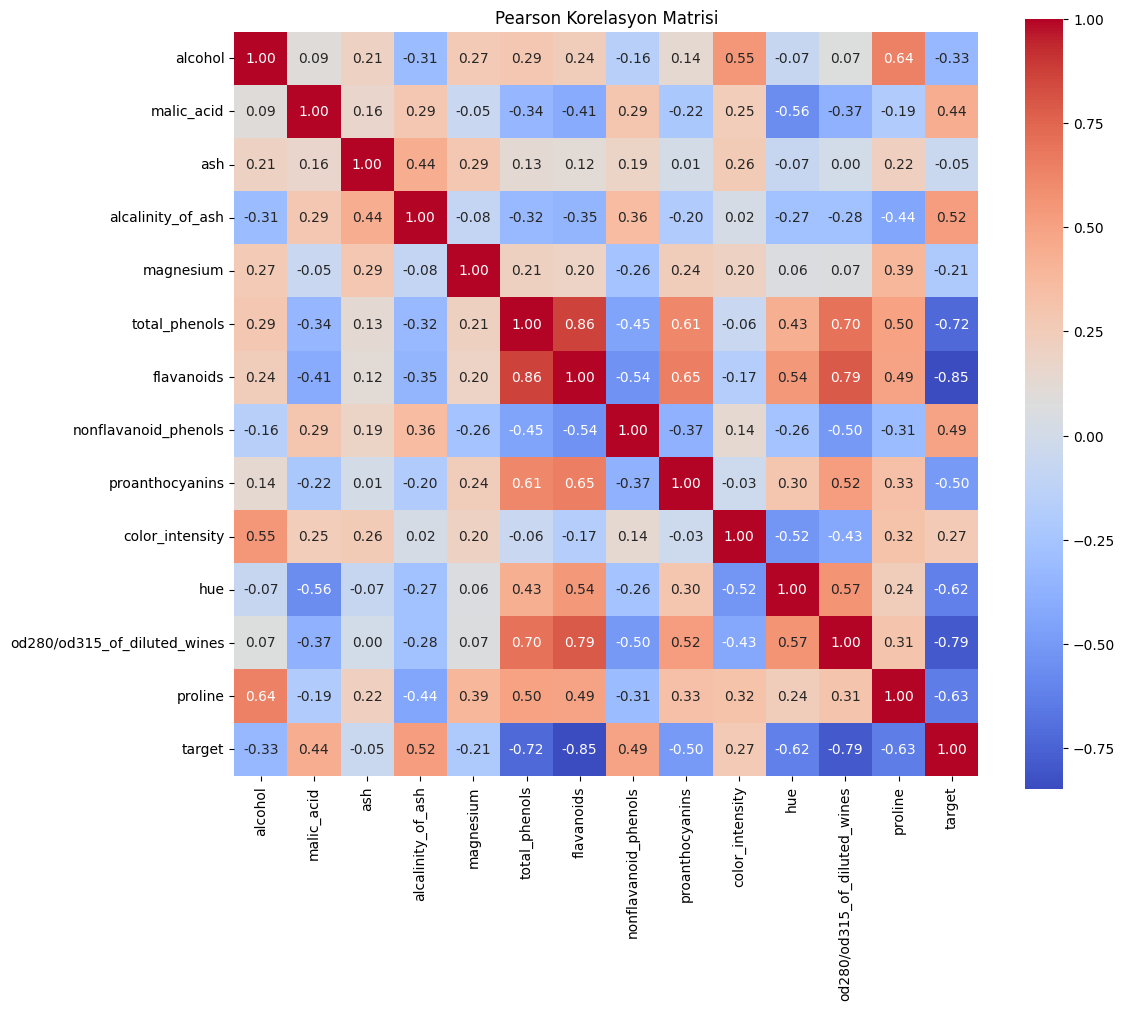


En Yüksek Pozitif Korelasyonlu 3 Çift:
 total_phenols  flavanoids                      0.864564
flavanoids     od280/od315_of_diluted_wines    0.787194
total_phenols  od280/od315_of_diluted_wines    0.699949
dtype: float64


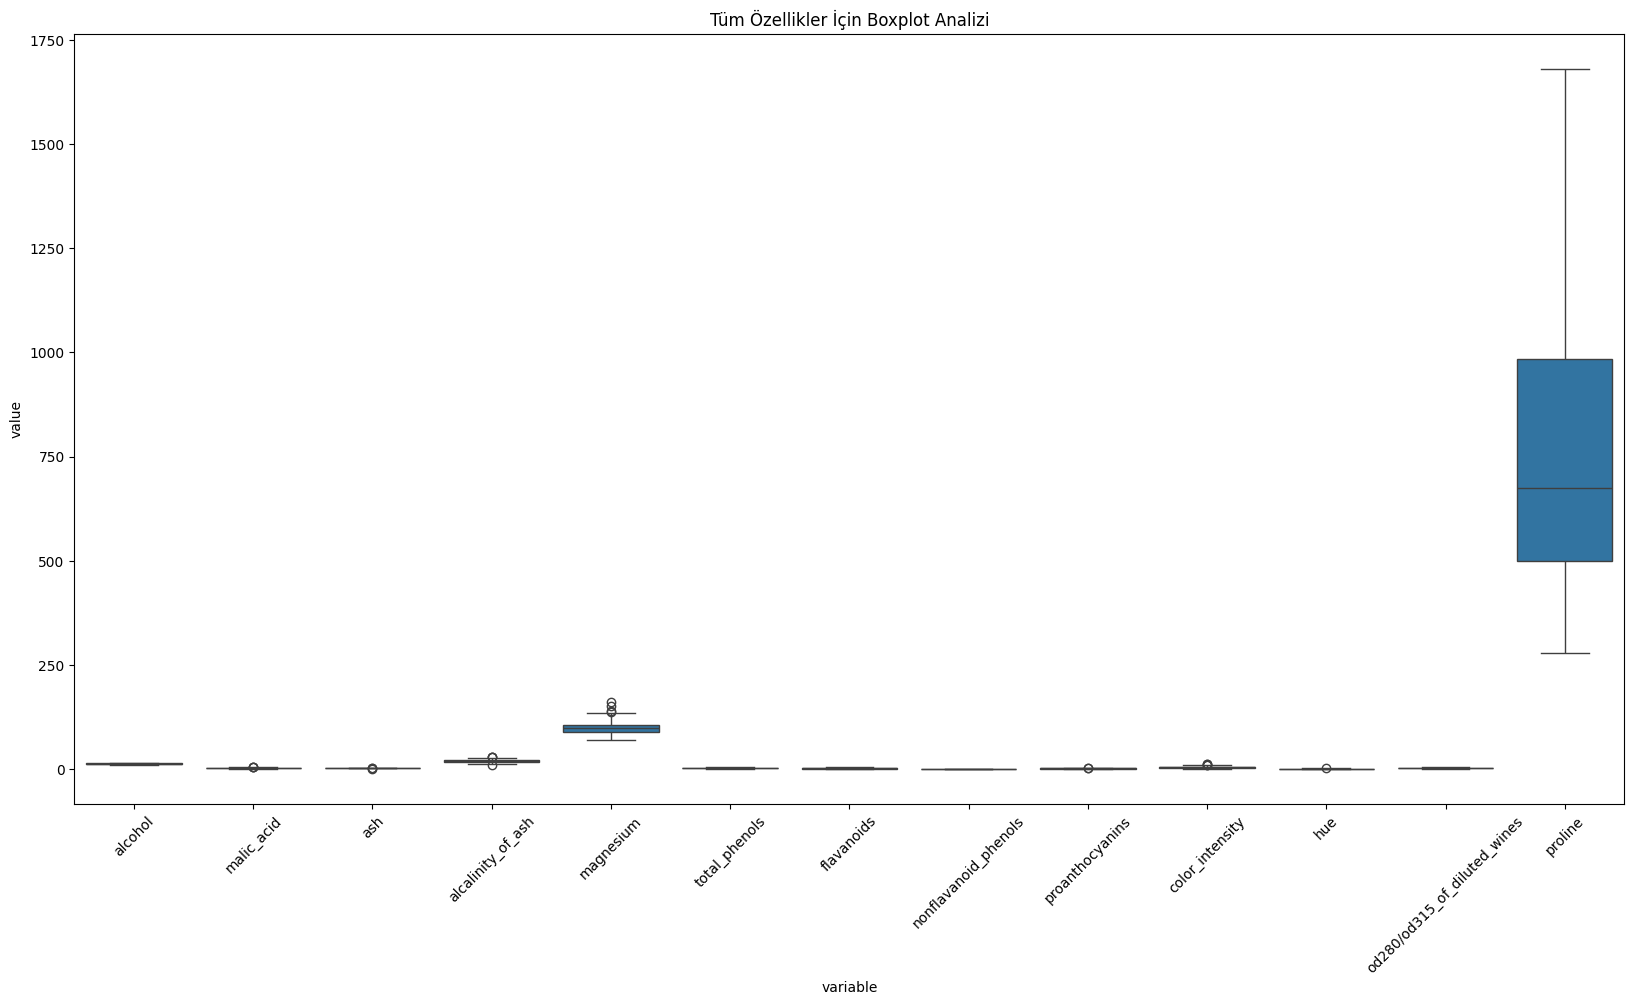

In [ ]:
# --- 3. Keşifsel Veri Analizi (EDA) ---
print("\n--- 3. Keşifsel Veri Analizi (EDA) ---")

# [cite_start]3.1 İstatistiksel Özellikler [cite: 27, 28]
print("İstatistiksel Özet:")
display(df.describe().T)

# [cite_start]3.2 Korelasyon Matrisi [cite: 34, 35, 36]
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Pearson Korelasyon Matrisi")
plt.show()

# [cite_start]En yüksek korelasyonlu çiftleri bulma [cite: 37]
# (Kendisi ile olan korelasyonları ve tekrar edenleri çıkararak)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_corrs = upper_tri.stack().sort_values(ascending=False).head(3)
print("\nEn Yüksek Pozitif Korelasyonlu 3 Çift:\n", top_corrs)

# [cite_start]3.3 Boxplot Analizi [cite: 38, 39]
plt.figure(figsize=(20, 10))
X_melted = pd.melt(df.drop('target', axis=1))
sns.boxplot(x="variable", y="value", data=X_melted)
plt.xticks(rotation=45)
plt.title("Tüm Özellikler İçin Boxplot Analizi")
plt.show()

Korelasyon Matrisi Yorumu:
- total_phenols + flavanoids: Bu iki özellik arasındaki çok güçlü pozitif korelasyon beklenen bir durumdur çünkü flavanoidler, toplam fenollerin bir alt grubudur. Şaraptaki fenolik bileşikler tat, renk ve antioksidan özellikler açısından belirleyicidir.

- flavanoids + od280/od315_of_diluted_wines: OD280/OD315 oranı, şaraptaki protein içeriğini ölçen spektroskopik bir parametredir. Flavanoidlerle güçlü ilişkisi, bu bileşiklerin şarabın kimyasal yapısını birlikte etkilediğini gösterir.

- total_phenols + od280/od315_of_diluted_wines: Fenolik bileşiklerin spektroskopik ölçümlerle tutarlı şekilde değişmesi, bu parametrelerin şarap kalitesinin güvenilir göstergeleri olduğunu ortaya koyar.

Target ile Korelasyonlar:

flavanoids (-0.85) ve total_phenols (-0.72) hedef değişkenle en güçlü negatif korelasyona sahiptir, bu da sınıflandırma için en ayırt edici özellikler olduğunu gösterir.

#### 3.1 İstatistiksel Özellikler

In [ ]:
print("İstatistiksel Özet:")
display(df.describe().T)

İstatistiksel Özet:


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


#### 3.2 Korelasyon Matrisi

Boxplot Analizi Yorumu
- magnesium: Üst sınırın üzerinde birkaç outlier mevcut (>140 mg/L). Bu değerler belirli üzüm çeşitlerine veya toprak minerallerine bağlı olabilir.
- proline: En geniş değer aralığına sahip özellik (278-1680). Outlier görülmemekle birlikte, yüksek varyans modelin bu özelliğe duyarlı olmasına neden olabilir.
- Ölçek Farkı: Proline (278-1680) ile hue (0.48-1.71) arasındaki büyük ölçek farkı, StandardScaler kullanımının gerekliliğini doğrulamaktadır.
- Genel Değerlendirme: Tespit edilen 17 aykırı değer, toplam verinin ~%10'unu oluşturmaktadır. Bu değerler doğal varyasyonu temsil edebileceğinden veri setinden çıkarılmamış, bunun yerine StandardScaler ile ölçeklendirme yapılarak etkisi minimize edilmiştir.

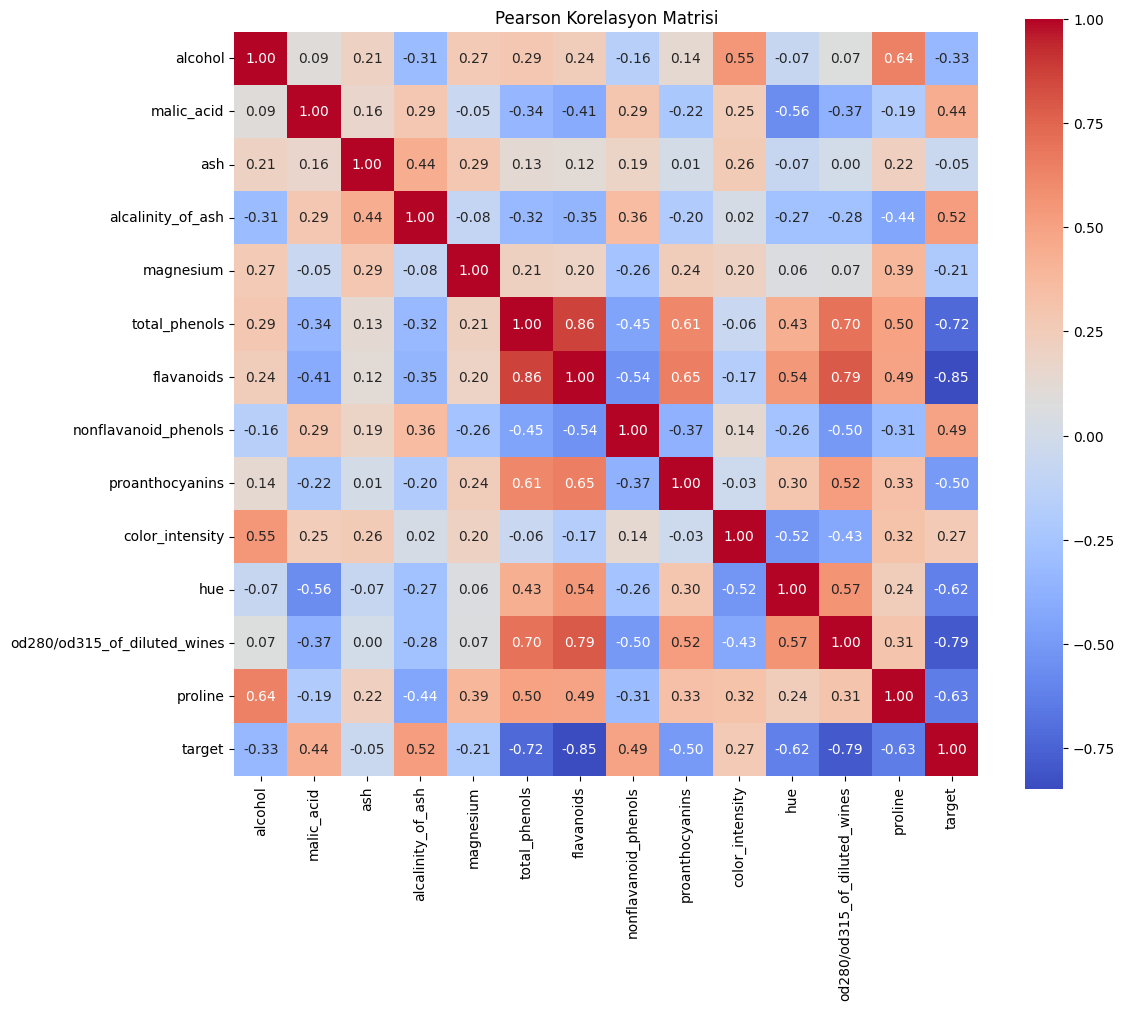

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Pearson Korelasyon Matrisi")
plt.show()

#### 3.3 Boxplot Analizi

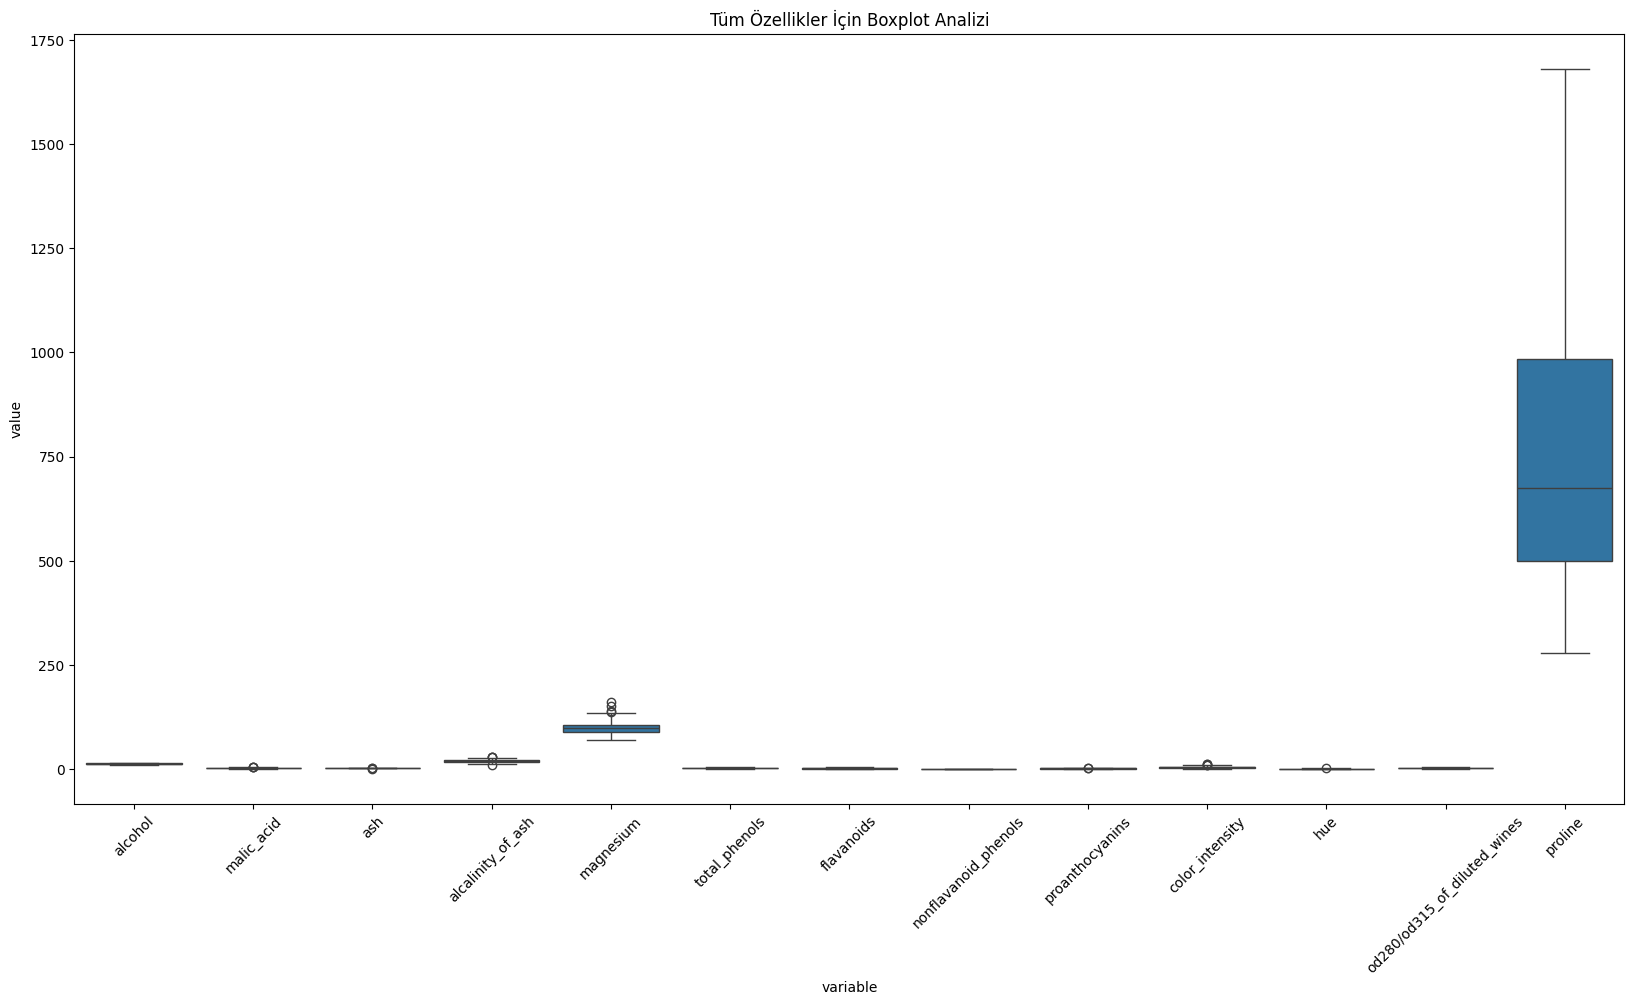

In [ ]:
plt.figure(figsize=(20, 10))
X_melted = pd.melt(df.drop('target', axis=1))
sns.boxplot(x="variable", y="value", data=X_melted)
plt.xticks(rotation=45)
plt.title("Tüm Özellikler İçin Boxplot Analizi")
plt.show()

### 4. Veri Setinin Bölünmesi - 5. Veri Ölçeklendirme (Scaling)

In [ ]:
# Hedef: %70 Train, %10 Validation, %20 Test

# Önce %20 Test ayırıyoruz
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

# Kalan %80'lik kısmı Train (%70) ve Validation (%10) olarak ayırıyoruz.
# %80'in 1/8'i %10 eder. Yani kalan verinin 0.125'i validation olmalı.
val_size = 0.125
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=RANDOM_SEED
)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Validation Seti Boyutu: {X_val.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

# 5. Veri Ölçeklendirme
scaler = StandardScaler()

# Sadece train set üzerinde fit ediyoruz!
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Veriler StandardScaler ile ölçeklendi.")

Eğitim Seti Boyutu: (124, 13)
Validation Seti Boyutu: (18, 13)
Test Seti Boyutu: (36, 13)
Veriler StandardScaler ile ölçeklendi.


### 6. Farklı MLP Modellerinin Kurulması

In [ ]:
# [cite_start]--- 6. Farklı MLP Modellerinin Kurulması [cite: 53, 54] ---

model_configs = [
    # [cite_start]Model 1
    {"name": "Model 1 (Basit)", "params": {"hidden_layer_sizes": (16,), "activation": "relu", "learning_rate_init": 0.001}},
    # [cite_start]Model 2
    {"name": "Model 2 (Orta)", "params": {"hidden_layer_sizes": (32, 16), "activation": "relu", "learning_rate_init": 0.005}},
    # [cite_start]Model 3
    {"name": "Model 3 (Geniş)", "params": {"hidden_layer_sizes": (64, 64), "activation": "tanh", "learning_rate_init": 0.001}},
    # [cite_start]Model 4
    {"name": "Model 4 (Derin)", "params": {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "learning_rate_init": 0.0005}},
    # [cite_start]Model 5
    {"name": "Model 5 (Düşük LR)", "params": {"hidden_layer_sizes": (32,), "activation": "relu", "learning_rate_init": 0.0001}}
]

### 7. Validation Performanslarının Ölçülmesi

In [ ]:
results = []
trained_models = {}

print("\n--- 7. Validation Performanslarının Ölçülmesi---")

for config in model_configs:
    # Modeli Tanımla (Sabit parametreler: max_iter, solver, random_state)
    mlp = MLPClassifier(**config["params"], max_iter=1000, random_state=RANDOM_SEED, solver='adam')

    # train et
    mlp.fit(X_train_scaled, y_train)
    trained_models[config["name"]] = mlp

    # validasyon setinde tahmin yap
    y_pred = mlp.predict(X_val_scaled)
    y_proba = mlp.predict_proba(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Multi-class ROC AUC
    try:
        auc_score = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
    except:
        auc_score = 0 # Hata durumunda (tek sınıf vs)

    results.append({
        "Model": config["name"],
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc_score
    })


results_df = pd.DataFrame(results)
display(results_df.sort_values(by="F1-Score", ascending=False))

# En iyi modeli seçme
best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
best_mlp_manual = trained_models[best_model_name]
print(f"\nSeçilen En İyi Model: {best_model_name}")


--- 7. Validation Performanslarının Ölçülmesi---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Model 1 (Basit),1.0,1.0,1.0,1.0,1.0
1,Model 2 (Orta),1.0,1.0,1.0,1.0,1.0
2,Model 3 (Geniş),1.0,1.0,1.0,1.0,1.0
3,Model 4 (Derin),1.0,1.0,1.0,1.0,1.0
4,Model 5 (Düşük LR),1.0,1.0,1.0,1.0,1.0



Seçilen En İyi Model: Model 1 (Basit)


### 8. En İyi Modelin Test Üzerinde Değerlendirilmesi

#### 8.1 Performans Metrikleri

In [ ]:
# [cite_start]--- 8. En İyi Modelin Test Üzerinde Değerlendirilmesi [cite: 83] ---
print(f"\n--- Test Performansı ({best_model_name}) ---")

y_test_pred = best_mlp_manual.predict(X_test_scaled)
y_test_proba = best_mlp_manual.predict_proba(X_test_scaled)

# [cite_start]8.1 Metrikler [cite: 86-91]
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted'):.4f}")


--- Test Performansı (Model 1 (Basit)) ---
Accuracy: 0.9444
Precision: 0.9466
Recall: 0.9444
F1-Score: 0.9443
ROC-AUC: 0.9951


#### 8.2 Confusion Matrix

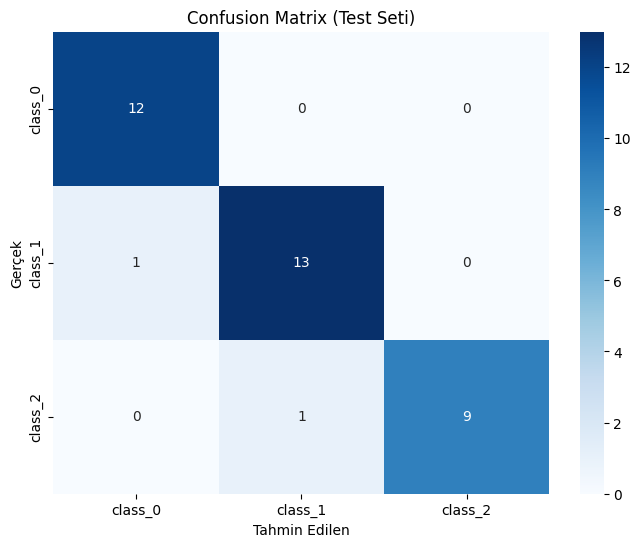

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix (Test Seti)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

#### 8.3 ROC Eğrisi

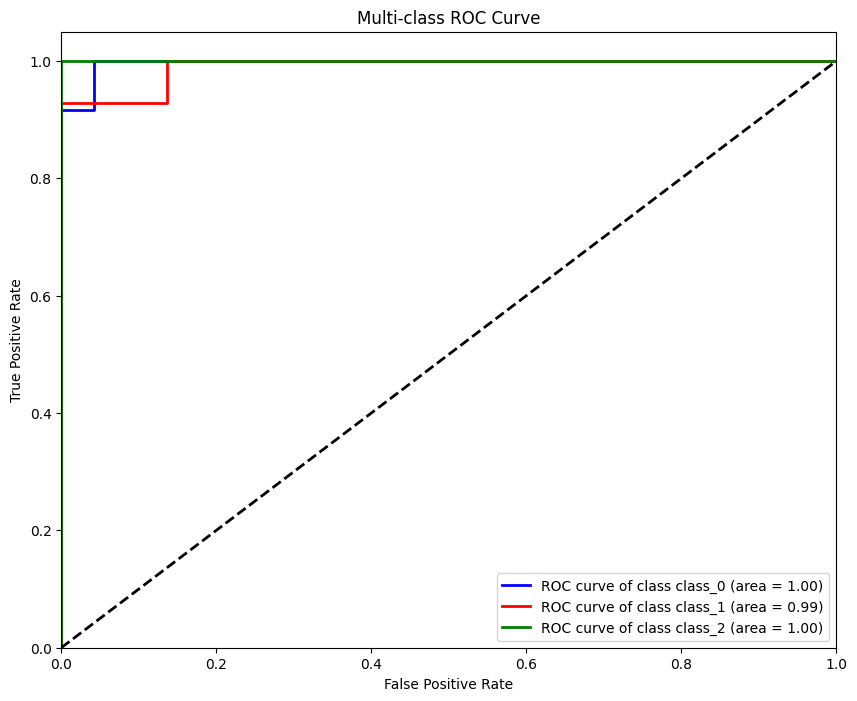

In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(data.target_names[i], auc(fpr, tpr)))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

### 9. Optuna ile Hiperparametre Optimizasyonu (150 Deneme)

In [ ]:
# 9. Optuna ile Hiperparametre Optimizasyonu
print("\n--- 9. Optuna Optimizasyonu Başlıyor (150 Deneme) ---")

def objective(trial):
    # 9.2 Arama Aralıkları
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 16, 256))

    hidden_layer_sizes = tuple(layers)

    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-1)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    activation = trial.suggest_categorical('activation', ["relu", "tanh"])
    solver = trial.suggest_categorical('solver', ["adam", "sgd"])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Model Tanımı
    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        max_iter=500,
        random_state=RANDOM_SEED
    )

    # 9.3 Eğitim Döngüsü
    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)
    score = f1_score(y_val, y_val_pred, average='weighted')

    return score

# 9.1 Study Tanımı
study = optuna.create_study(direction="maximize")
# Deneme sayısını 150 olarak ayarlıyoruz
study.optimize(objective, n_trials=150, show_progress_bar=True)

# 9.4 En İyi Trial Raporlanması
print("\nEn İyi Parametreler:", study.best_params)
print("En İyi Validation F1-Score:", study.best_value)

# En iyi parametrelerle modeli yeniden oluşturup eğitelim
best_params = study.best_params.copy()
# Layer yapısını parse edelim
n_layers_opt = best_params.pop('n_layers')
layers_opt = []
keys_to_remove = []
for k, v in best_params.items():
    if k.startswith('n_units_l'):
        layers_opt.append(v)
        keys_to_remove.append(k)
for k in keys_to_remove:
    best_params.pop(k)

best_mlp_optuna = MLPClassifier(
    hidden_layer_sizes=tuple(layers_opt),
    **best_params,
    max_iter=1000,
    random_state=RANDOM_SEED
)

best_mlp_optuna.fit(X_train_scaled, y_train)
print("Optuna modeli tüm eğitim verisiyle eğitildi.")

[I 2025-11-28 19:56:17,470] A new study created in memory with name: no-name-c4b8ec4c-3d82-4fce-92ee-7f20f231a0d0



--- 9. Optuna Optimizasyonu Başlıyor (150 Deneme) ---


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-28 19:56:28,234] Trial 0 finished with value: 1.0 and parameters: {'n_layers': 3, 'n_units_l0': 101, 'n_units_l1': 27, 'n_units_l2': 251, 'learning_rate_init': 0.00010285923323449942, 'alpha': 5.212149931589513e-06, 'activation': 'tanh', 'solver': 'sgd', 'batch_size': 16}. Best is trial 0 with value: 1.0.
[I 2025-11-28 19:56:46,067] Trial 1 finished with value: 1.0 and parameters: {'n_layers': 3, 'n_units_l0': 62, 'n_units_l1': 231, 'n_units_l2': 68, 'learning_rate_init': 5.107981911553299e-05, 'alpha': 0.0006893113564161813, 'activation': 'tanh', 'solver': 'sgd', 'batch_size': 32}. Best is trial 0 with value: 1.0.
[I 2025-11-28 19:56:49,247] Trial 2 finished with value: 1.0 and parameters: {'n_layers': 3, 'n_units_l0': 107, 'n_units_l1': 62, 'n_units_l2': 73, 'learning_rate_init': 1.340301579649309e-05, 'alpha': 0.00026879376807826595, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 1.0.
[I 2025-11-28 19:56:49,725] Trial 3 finished wit

### 10. XAI – SHAP Açıklanabilirlik Analizi (Zorunlu)

In [ ]:

# SHAP için arka plan verisi (K-means özeti)
X_train_summary = shap.kmeans(X_train_scaled, 10)

def run_shap_analysis(model, model_name, X_data):
    print(f"\nAnalyzing: {model_name}")

    explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

    X_data_np = X_data.values if hasattr(X_data, "values") else X_data
    shap_values = explainer.shap_values(X_data_np)

    # SHAP değerlerinin yapısını kontrol et
    print(f"SHAP values type: {type(shap_values)}")
    if isinstance(shap_values, list):
        print(f"Number of classes: {len(shap_values)}")
        print(f"Shape per class: {shap_values[0].shape}")
    else:
        print(f"SHAP values shape: {shap_values.shape}")
    print(f"X_data shape: {X_data_np.shape}")

    feature_names = list(X_data.columns) if hasattr(X_data, "columns") else data.feature_names

    # Summary Plot (Bar)
    plt.figure()
    plt.title(f"SHAP Summary Bar Plot - {model_name}")
    shap.summary_plot(shap_values, X_data_np, feature_names=feature_names, plot_type="bar", show=False)
    plt.show()

    # Beeswarm için doğru şekilde veri geçir
    print(f"Sınıf 1 ({data.target_names[1]}) için detaylı analiz:")
    plt.figure()
    plt.title(f"SHAP Beeswarm Plot (Class 1) - {model_name}")

    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_data_np, feature_names=feature_names, show=False)
    else:
        # Eğer 3D array ise (samples, features, classes)
        shap.summary_plot(shap_values[:, :, 1], X_data_np, feature_names=feature_names, show=False)

    plt.show()

    return explainer, shap_values

#### 10.1 Beş MLP Modelinden validasyon başarısına göre seçilen model için SHAP Analizi


Analyzing: Manuel En İyi Model


  0%|          | 0/36 [00:00<?, ?it/s]

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (36, 13, 3)
X_data shape: (36, 13)


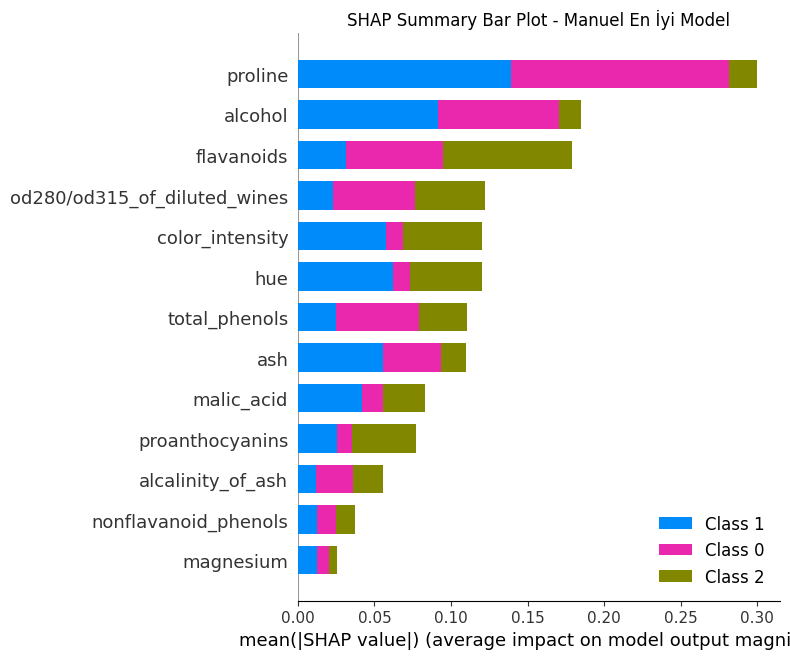

Sınıf 1 (class_1) için detaylı analiz:


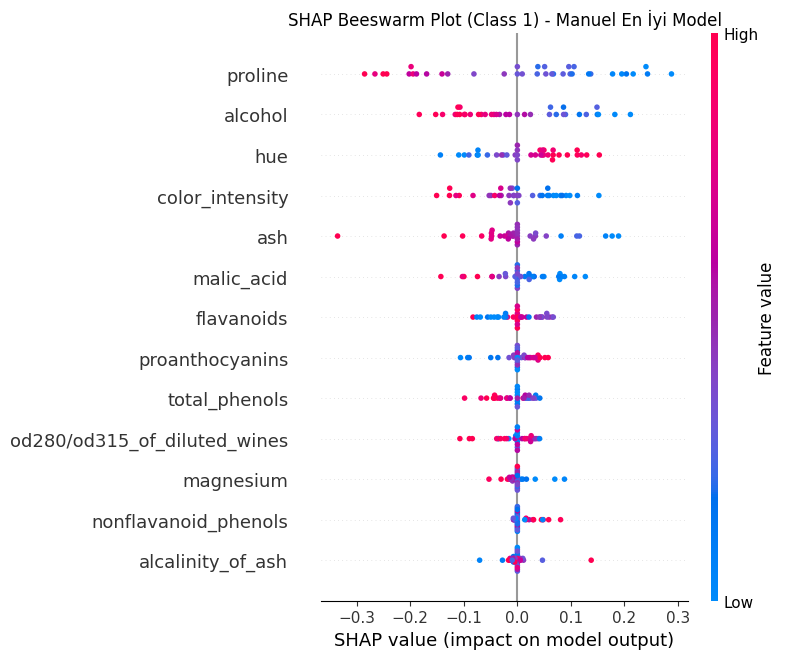

In [ ]:
explainer_manual, shap_values_manual = run_shap_analysis(best_mlp_manual, "Manuel En İyi Model", X_test_scaled)

#### 10.2 Optuna En İyi Model için SHAP Analizi


Analyzing: Optuna En İyi Model


  0%|          | 0/36 [00:00<?, ?it/s]

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (36, 13, 3)
X_data shape: (36, 13)


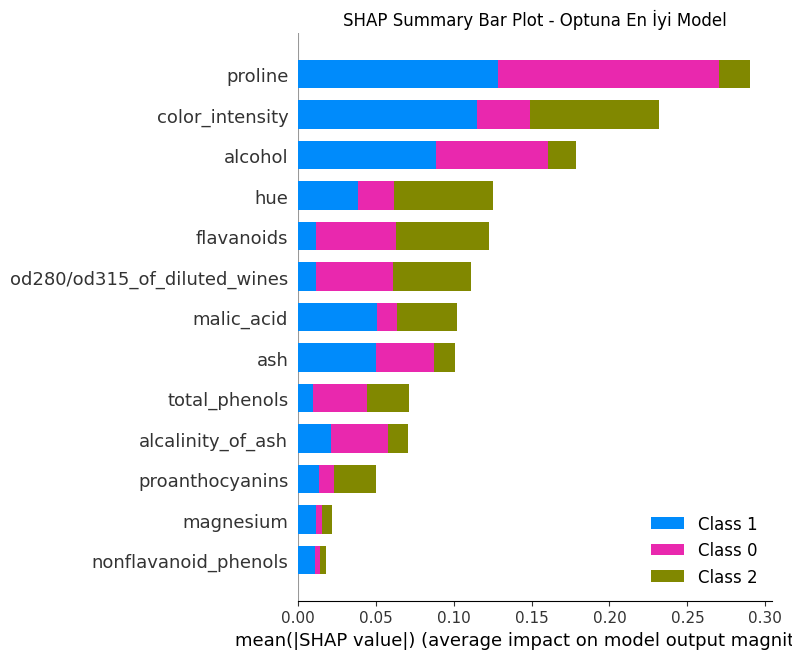

Sınıf 1 (class_1) için detaylı analiz:


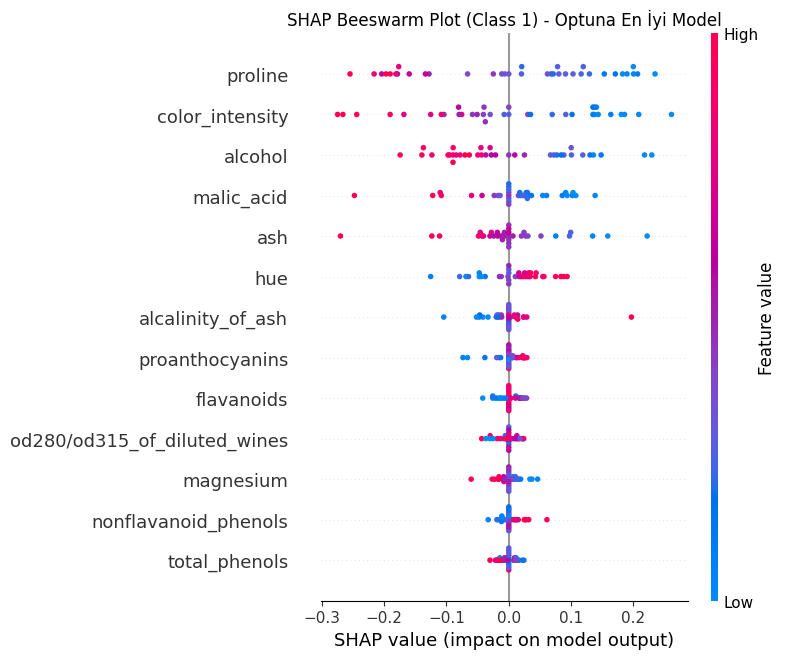

In [ ]:
explainer_optuna, shap_values_optuna = run_shap_analysis(best_mlp_optuna, "Optuna En İyi Model", X_test_scaled)


SHAP Force Plot ve Decision Plot Analizi



Force Plot (İlk test örneği, Sınıf 1 için):


<Figure size 640x480 with 0 Axes>

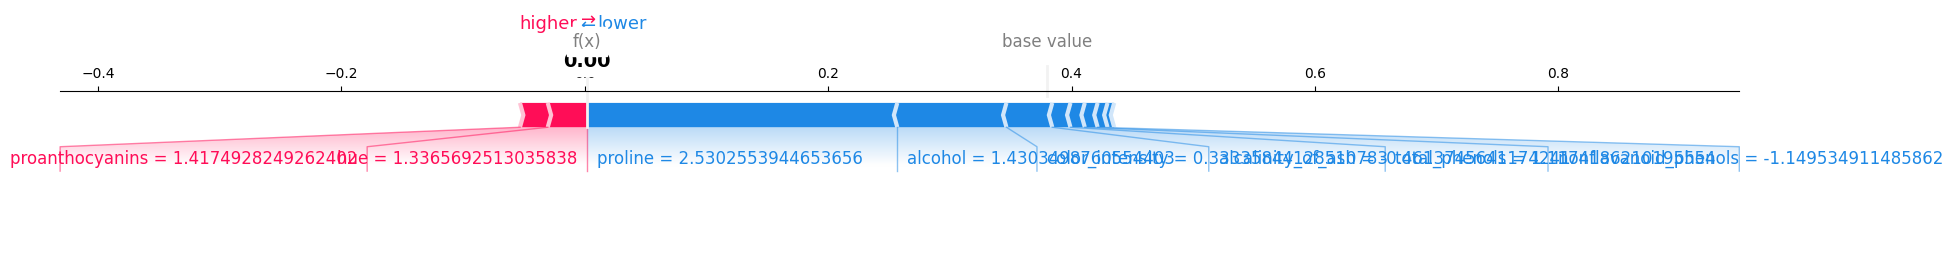


Decision Plot (İlk 10 test örneği, Sınıf 1 için):


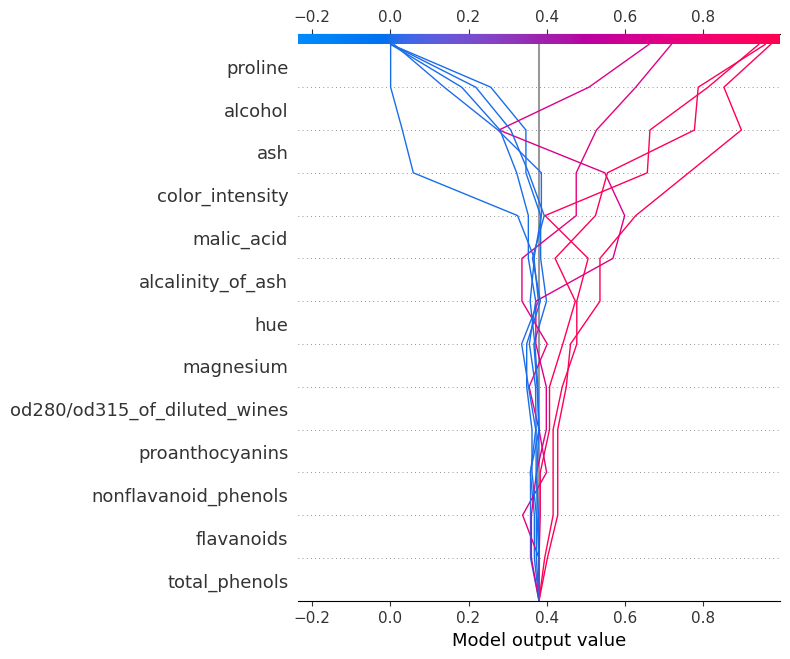

In [ ]:
print("\n" + "="*50)
print("SHAP Force Plot ve Decision Plot Analizi")
print("="*50)

shap.initjs()

# SHAP değerlerinin yapısını kontrol et
if isinstance(shap_values_optuna, list):
    # Eski SHAP yapısı (list of arrays)
    sv_class1 = shap_values_optuna[1]
    expected_val = explainer_optuna.expected_value[1]
else:
    # Yeni SHAP yapısı (3D array: samples x features x classes)
    sv_class1 = shap_values_optuna[:, :, 1]
    expected_val = explainer_optuna.expected_value[1]

# Force Plot - İlk test örneği
print("\nForce Plot (İlk test örneği, Sınıf 1 için):")
plt.figure()
shap.force_plot(expected_val, sv_class1[0, :], X_test_scaled.iloc[0, :], matplotlib=True, show=False)
plt.tight_layout()
plt.show()

# Decision Plot - İlk 10 test örneği
print("\nDecision Plot (İlk 10 test örneği, Sınıf 1 için):")
plt.figure()
shap.decision_plot(expected_val, sv_class1[:10, :], feature_names=list(X_test_scaled.columns), show=False)
plt.tight_layout()
plt.show()